# **Aim**
To explore characteristics of amyloid shape and distribution for better detection algorithms


# 1) Select Image

<br>

**Image Description:**

A microscopic image of senile plaques seen in the cerebral cortex of a person with Alzheimer's disease of presenile onset *(blue arrows indicate plaques location)*

**What are amyloid plaques?**

 - Beta-amyloid protein, formed from breakdown of a larger protein (amyloid precursor protein) come in different forms which collect between neurons

 - Abnormal levels of this naturally occurring protein clump together to form plaques that collect between neurons and disrupt cell function

<br>
<img src = "az1.png" style = "width:500px; height:400px"/>

*(Source: National Science Foundation, https://www.nsf.gov/discoveries/disc_summ.jsp?cntn_id=134049)*

In [ ]:
# Import necessary libraries

from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
%matplotlib inline

Original image:


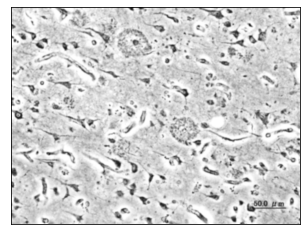

In [9]:
# Read in image

filename = 'Alzheimer_presenile_onset.jpg'

img = cv2.imread(filename,0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
print("Original image:")
plt.show()

# 2) Qualitative Assessment: Thresholding

**Question:**
 - Where to apply threshold?
 - Looking at histogram of intensity pixels
 
**Results:**
 - Cells absorb light causing darker regions to appear in image
 - Majority of pixels are in 170-230 intensity range – seems to be relatively good threshold
 - No visible “peaks” or obvious pixel value segregation with objects in image

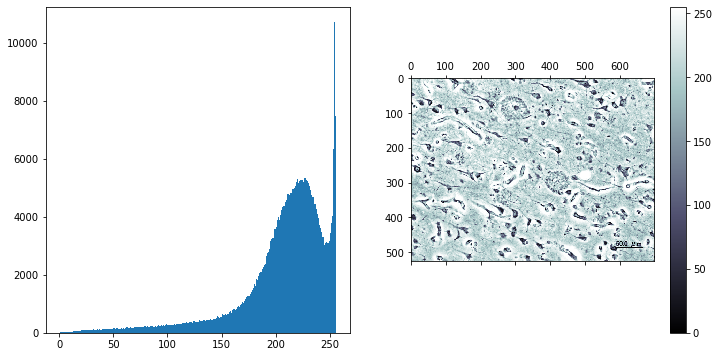

In [10]:
# Threshold based on pixel intensity

nonsegmented_img = rgb2gray(imread(filename))
fig, (ax_hist, ax_img) = plt.subplots(1, 2, figsize = (12,6))
ax_hist.hist(img.ravel(),256,[0,256])
ax_obj = ax_img.matshow(img, cmap = 'bone')
plt.colorbar(ax_obj)

**Question / Purpose:**
 - Try out a number of different thresholds to find best
 
**Results:**
 - Lot of noise and artifacts 
 - Catches the whole range of cells since they all have similar absorption capacity regardless of type / shape
 - Cleanest image around 125-150 range


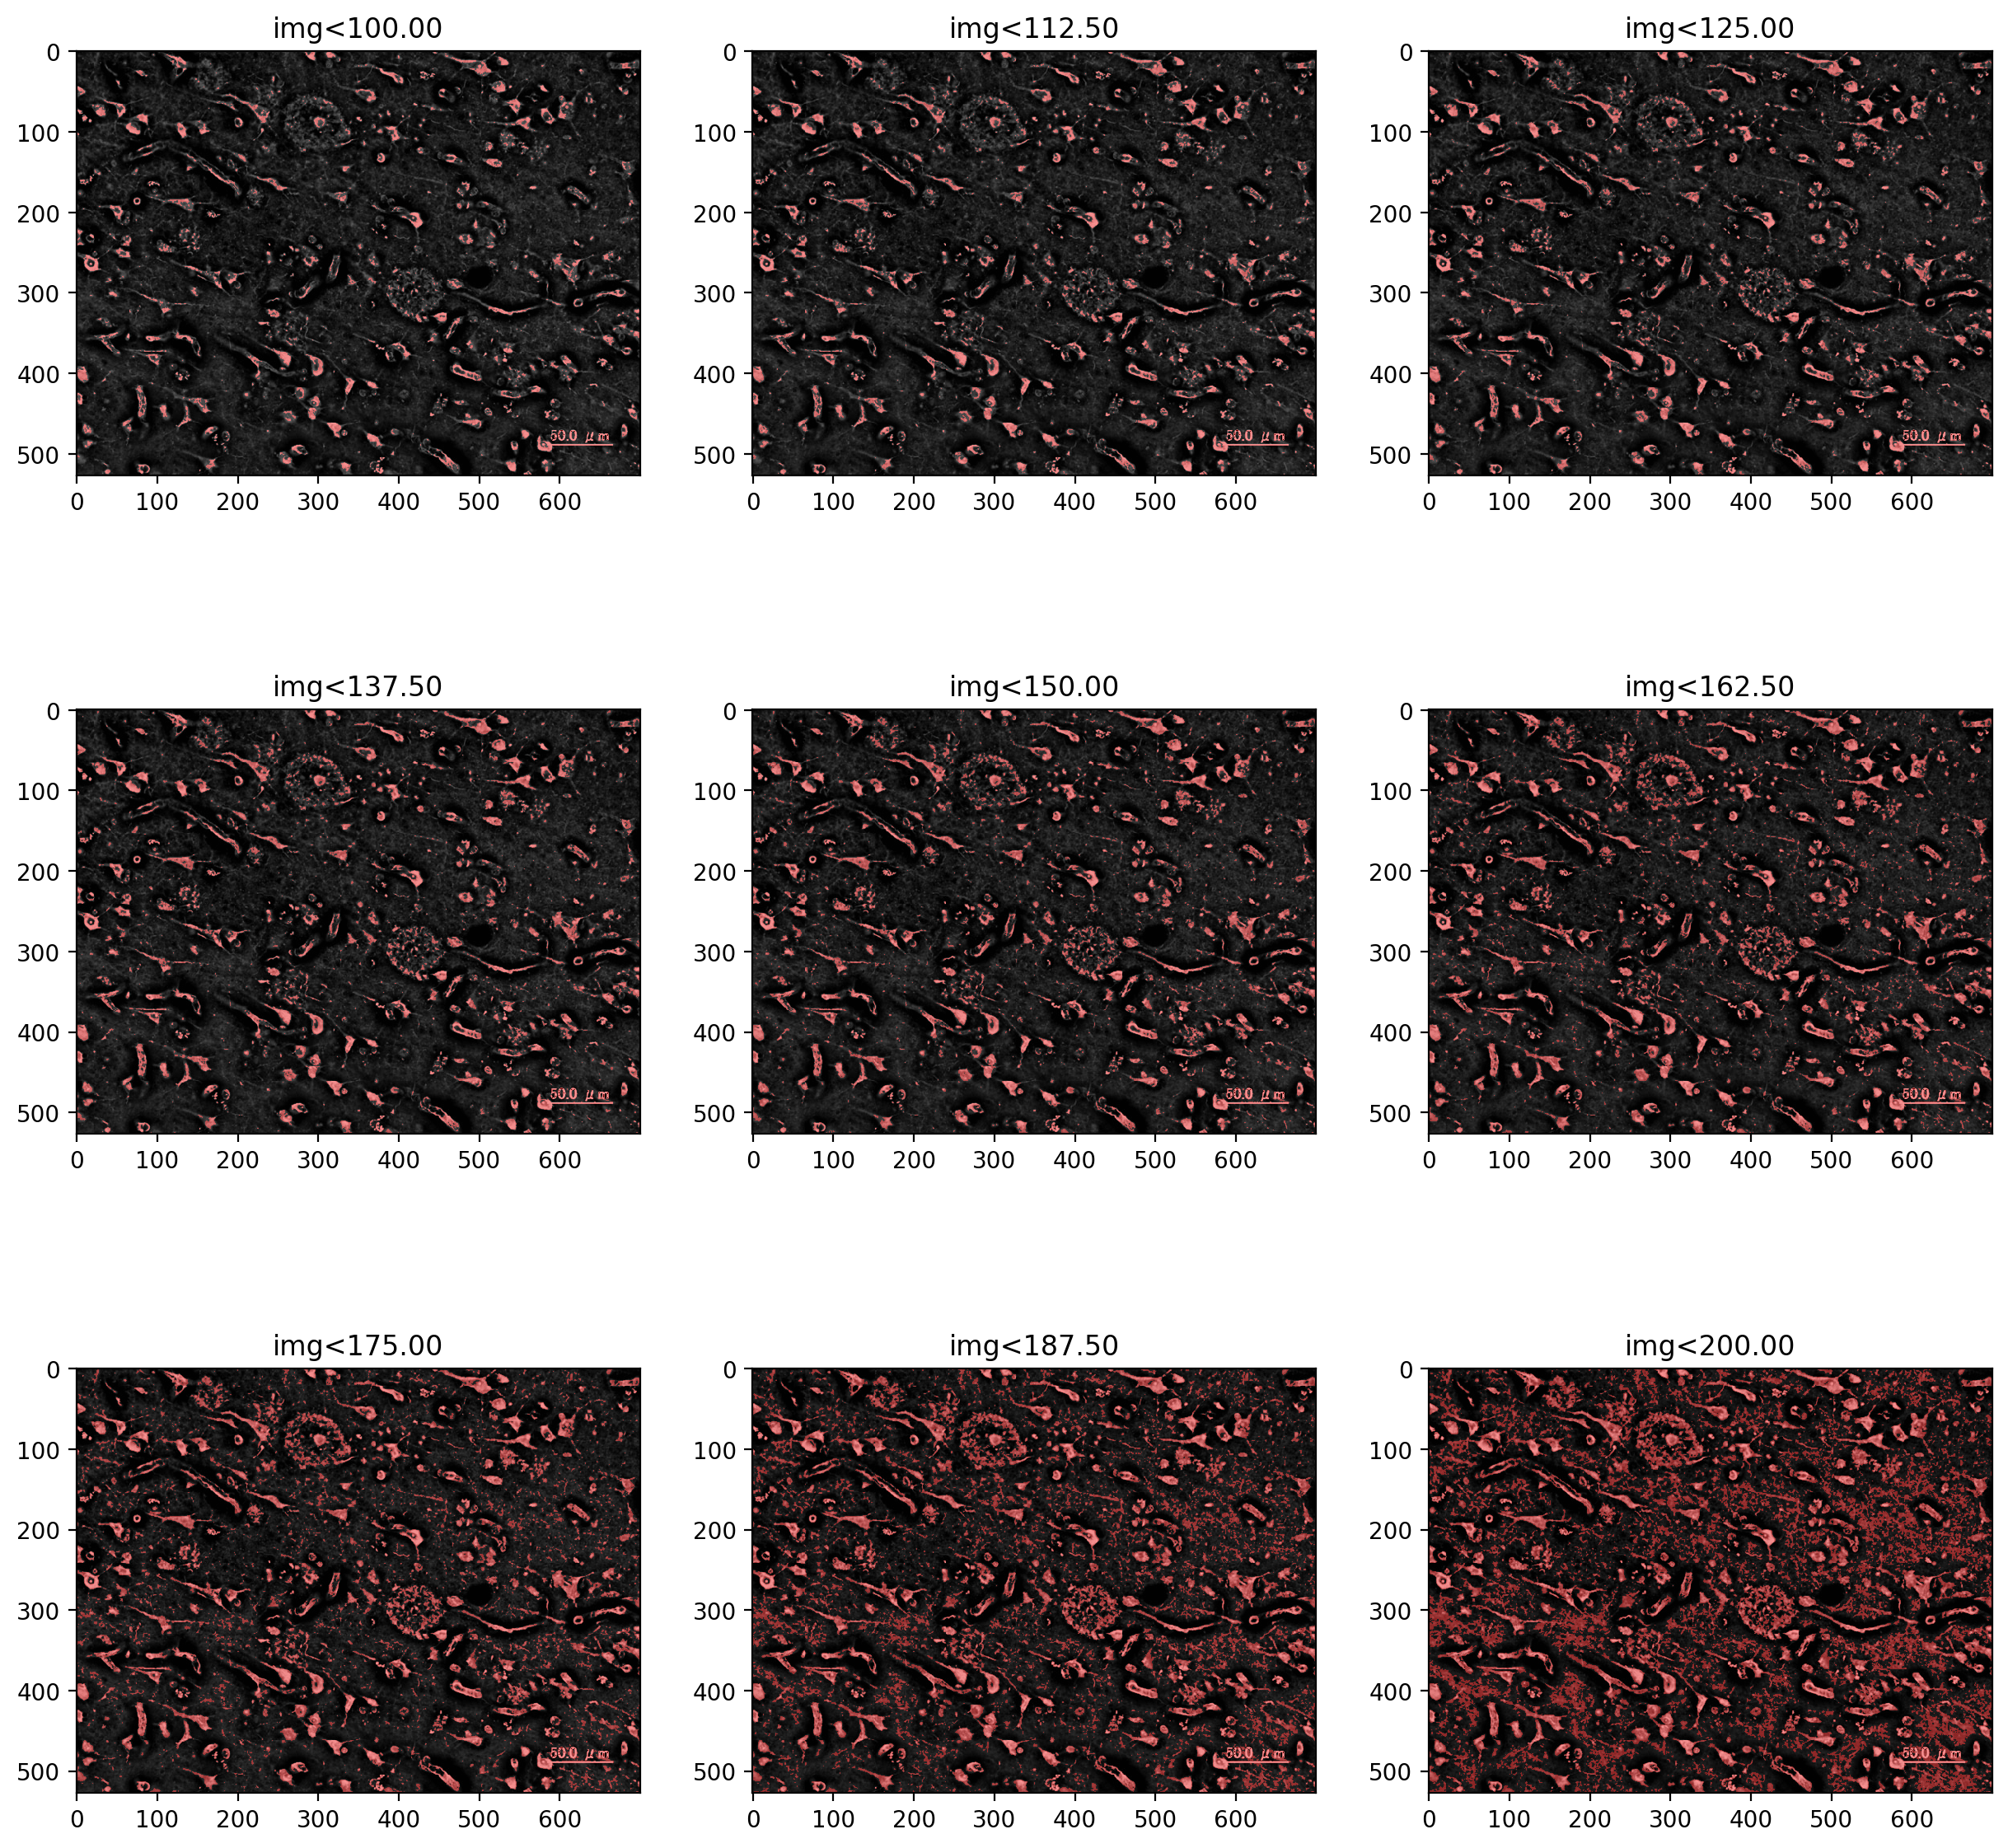

In [12]:
# Try different threshold levels

from skimage.color import label2rgb
fig, m_axs = plt.subplots(3,3, figsize = (15, 15), dpi = 200)
for c_thresh, ax1 in zip(np.linspace(100, 200, 9), m_axs.flatten()):
    thresh_img = img < c_thresh

    ax1.imshow(label2rgb(thresh_img, image = 1-img, bg_label = 0, alpha = 0.4))
    
    ax1.set_title('img<%2.2f' % c_thresh)

# 3) Hand-labeling Plaques

<br>

**Where datasets and ground truths become important:**
 - Rather than going through and tweaking threshold values until it looks good..
 - Take image, manually went through with paintbrush and marked image based on our “expert” understanding given certain texture and pattern 
 
**Procedure:**
 - Hand drawn / painted over plaques to indicate location
 - Applied threshold to create a “labeled image”

**Goal:**
 - Identify what class each pixel belongs to 
 - Want to be able to take a pixel and decide if its part of plaque or outside it 

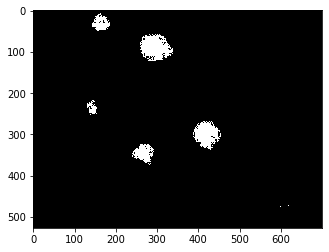

In [14]:
# Create Labels for AD plaques (hand-colored in black - thresholding to see labeled plaques only) 

# Read in labeled image
img_marked = cv2.imread('Alzheimer_presenile_onset_colored.jpg',0)
img_marked_edited = 1-(img_marked >0.5)
plt.imshow(img_marked_edited,cmap='bone')

# 4) Pixel Class Identification
<br>

**Goal:**

 - Want to identify which class each pixel belongs to
 - Classify pixels in plaque as Foreground
 - Classify pixels outside plaque as Background


Text(0.5, 1.0, 'Plaque Labels')

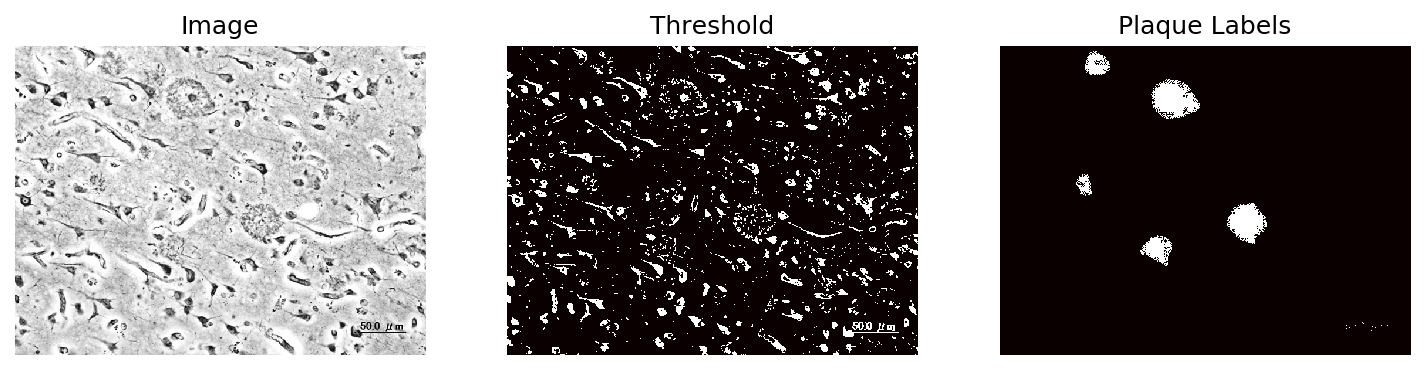

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
ax1.imshow(img, cmap='gray')
thresh_img = img < 150
ax2.imshow(thresh_img, cmap='hot')
ax3.imshow(img_marked_edited, cmap='hot')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('Image')
ax2.set_title('Threshold')
ax3.set_title('Plaque Labels')

**How to quantify this?**

 - True Positive = values in plaques classified as Foreground
 - True Negative = values outside plaques classified as Background
 - False Positive = values outside plaques classified as Foreground
 - False Negative = values in plaques classified as Background

**Result:**
 - Recall (0.25) and Precision (0.06) not so great..


Recall: 0.20
Precision: 0.06


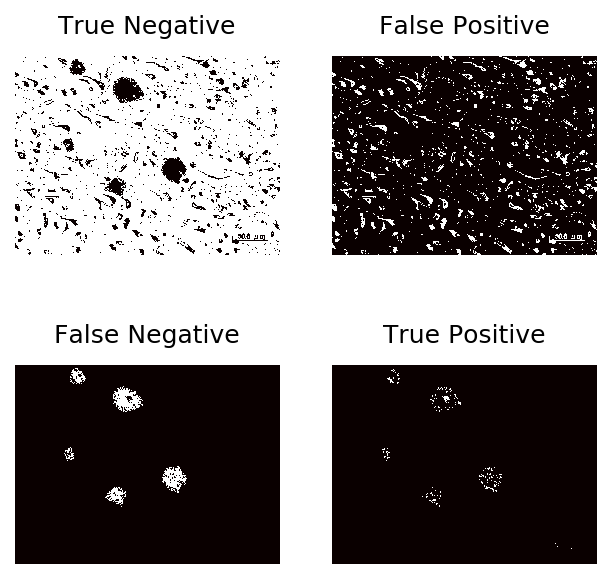

In [23]:
# Find TP, TN, FP, FN

def tp_func(real_img_idx, pred_img_idx):
    if real_img_idx == 1 and pred_img_idx == 1:
        return 'True Positive'
    if real_img_idx == 0 and pred_img_idx == 0:
        return 'True Negative'
    if real_img_idx == 0 and pred_img_idx == 1:
        return 'False Positive'
    if real_img_idx == 1 and pred_img_idx == 0:
        return 'False Negative'


out_results = {}
fig, m_ax = plt.subplots(2, 2, figsize=(5, 5), dpi=150)
for real_img_idx, n_ax in zip([0, 1], m_ax):
    for pred_img_idx, c_ax in zip([0, 1], n_ax):
        match_img = (thresh_img == pred_img_idx) & (img_marked_edited == real_img_idx)
        tp_title = tp_func(real_img_idx, pred_img_idx)
        c_ax.matshow(match_img, cmap='hot')
        out_results[tp_title] = np.sum(match_img)
        c_ax.set_title(tp_title)
        c_ax.axis('off')
# print(out_results)


# Determine Precision & Recall

print('Recall: %2.2f' % (out_results['True Positive'] /
                         (out_results['True Positive']+out_results['False Negative'])))
print('Precision: %2.2f' % (out_results['True Positive'] /
                            (out_results['True Positive']+out_results['False Positive'])))

In [25]:
# # View from different thresholds

# from collections import OrderedDict

# out_vals = []
# for thresh_val in np.linspace(100, 250):
#     thresh_img = img < thresh_val
#     for real_img_idx in [0, 1]:
#         for pred_img_idx in [0, 1]:
#             match_img = (thresh_img == pred_img_idx) & (
#                 img == real_img_idx)
#             tp_title = tp_func(real_img_idx, pred_img_idx)
#             out_results[tp_title] = np.sum(match_img)
#     out_vals += [
#         OrderedDict(
#             Threshold=thresh_val,
#             Recall=out_results['True Positive'] /
#             (out_results['True Positive']+out_results['False Negative']),
#             Precision=(out_results['True Positive'] /
#                        (out_results['True Positive']+out_results['False Positive'])),
#             False_Positive_Rate=(out_results['False Positive'] /
#                        (out_results['False Positive']+out_results['True Negative'])),
#             **out_results
#         )]

# roc_df = pd.DataFrame(out_vals)
# roc_df.head(3)

# 5) Filter the Image

 - Plaques are not unique enough?
 - Neither entirely connected nor have strong absorption compared to other types of cells
 - Seems more an issue of shape

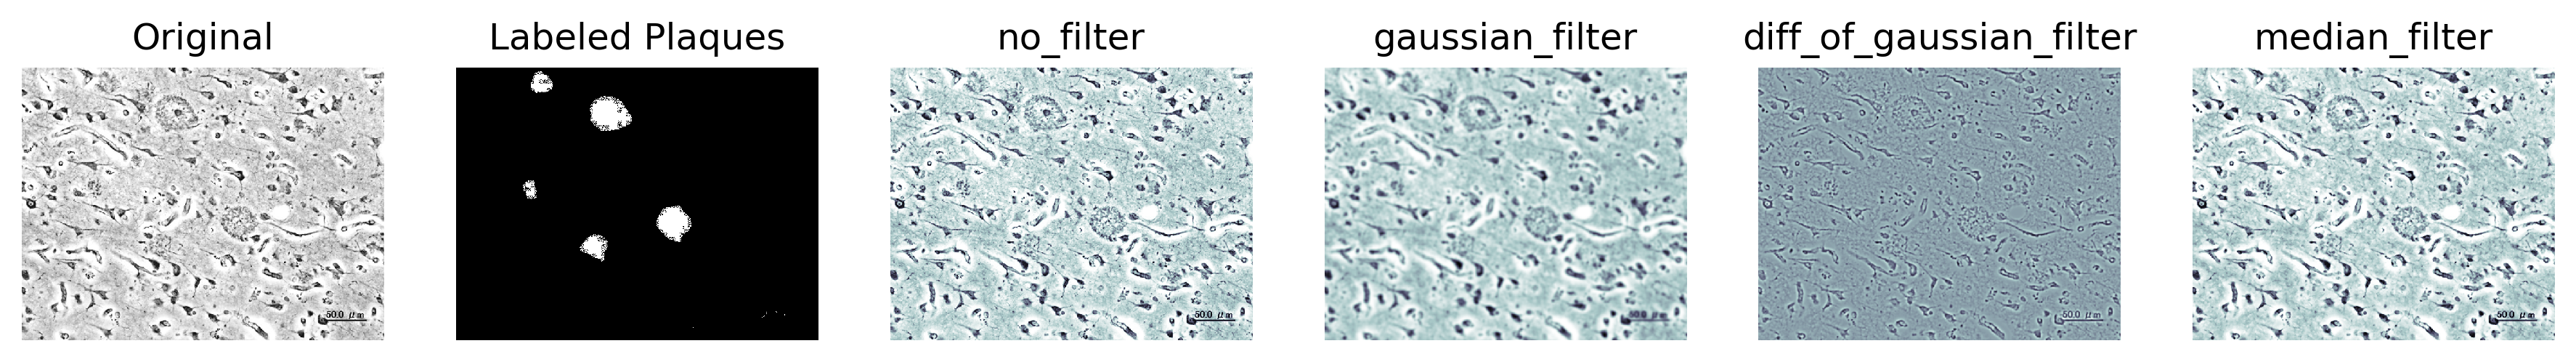

In [26]:
# Trying out different filters

from skimage.filters import gaussian, median

def no_filter(x):
    return x

def gaussian_filter(x):
    return gaussian(x, sigma=2)

def diff_of_gaussian_filter(x):
    return gaussian(x, sigma=1)-gaussian(x, sigma=3)

def median_filter(x):
    return median(x, np.ones((3, 3)))

fig, m_axs = plt.subplots(1, 6, figsize=(15, 3), dpi=300)
m_axs[0].imshow(img, cmap='gray')
m_axs[0].set_title('Original')
m_axs[0].axis('off')
m_axs[1].imshow(img_marked_edited, cmap='gray')
m_axs[1].axis('off')
m_axs[1].set_title('Labeled Plaques')

for c_filt, c_ax in zip([no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter], m_axs[2:]):
    c_ax.imshow(c_filt(img), cmap='bone')
    c_ax.set_title(c_filt.__name__)
    c_ax.axis('off')

# 6) Applying Various Thresholds to Segment

<br>

**Procedure:**

 - Chose 4 arbitrary ranges for different phases and performed visual inspection

**Result:**

 - Thresholding - does not work! 
 - No separate peaks in histogram, not sufficient to label structure
 - No major differences in brightness (regardless of cell type) 
 - None of the cutoff points are any good..
 - There are no distinct classes / phases (unlike “segmenting shale” example with distinctive clay, rock and air)

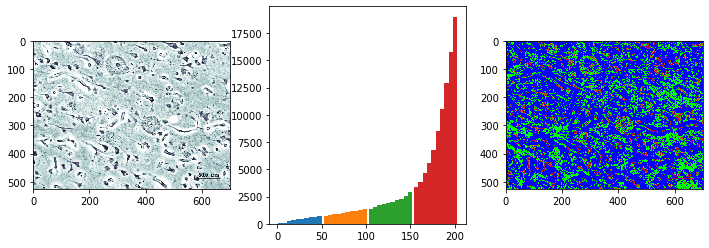

In [27]:
# Apply various thresholds to segment

np.random.seed(100)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (12, 4), dpi = 72)
ax1.imshow(img, cmap = 'bone')
thresh_vals = np.linspace(img.min(), img.max(), 6)[:-1]
out_img = np.zeros_like(img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (img>t_start) & (img<t_end)
    ax2.hist(img.ravel()[thresh_reg.ravel()])
    out_img[thresh_reg] = i
ax3.imshow(out_img, cmap = 'brg');

**Automatic Threshold Selection:**
 - Again, issue lies in being a distinction in tiny structures (dependent on shape)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


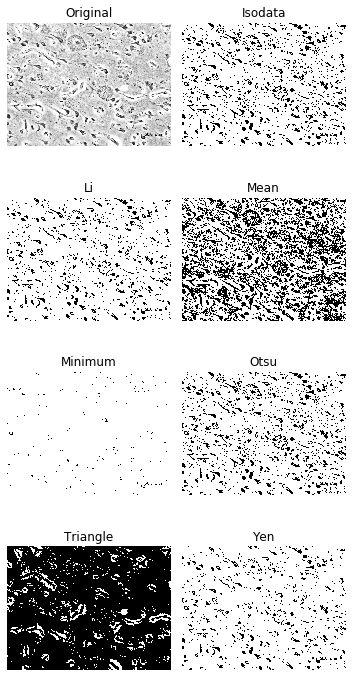

In [28]:
# Automatic thresholding
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(img, figsize=(5, 10), verbose=True)


# 7) Hysteresis Thresholding

**Goldilocks Thresholding:**

 - Where single thresholds don’t work – have larger structures clearly defined and smaller structures which are difficult to differentiate
 - "Goldilocks situation:" one threshold too low and one too high, gets cells but also lot of artifacts


Text(0.5, 1.0, 'Threshold $<$ 204')

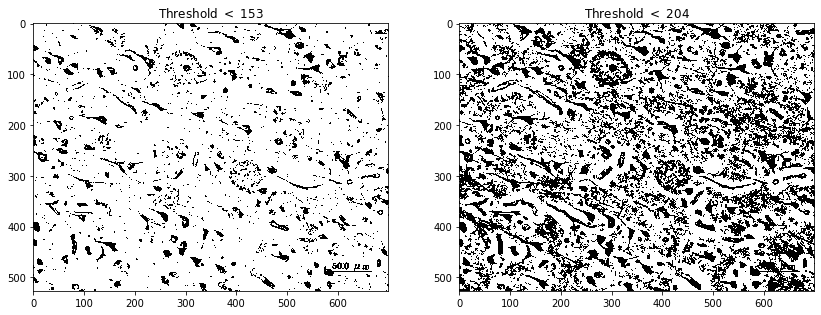

In [35]:
# Perform Goldilocks Thresholding

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.imshow(img<thresh_vals[3], cmap = 'bone_r')
ax1.set_title('Threshold $<$ %d' % (thresh_vals[3]))
ax2.imshow(img<thresh_vals[4], cmap = 'bone_r')
ax2.set_title('Threshold $<$ %d' % (thresh_vals[4]))



**Reducing Pixels**

**Goal:** Happy medium between two - use hysteresis thresholding to combine images together
 - 1) Take more strict threshold as initial starting point (things we are very confident are cells)
 - 2) Remove objects that are too small using opening operation
 - 3) Take 2nd threshold at higher value
 - 4) Combine both images together by only keeping pixels which are connected (“between pixels”) and ignore others 
** Assumes noise structures here are only meaningful if they are connected already to one of these cells

**Results:** 
Works decently well, can see the amyloid shapes more clearly


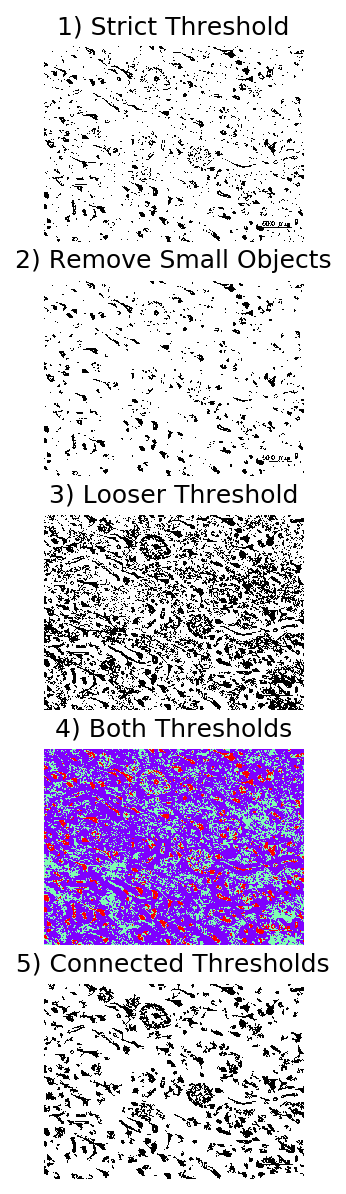

In [36]:
# Hysteresis Thresholding: Reducing Pixels
# 1) Take first threshold image with the highest (more strict) threshold
# 2) Remove the objects which are not cells (too small) using an opening operation.
# 3) Take second threshold image with the higher value
# 4) Combine both threshold images
# 5) Keep the between pixels which are connected (by looking again at a neighborhood $\mathcal{N}$) to the air voxels and ignore the other ones. This goes back to our original supposition that the smaller structures are connected to the larger structures

from skimage.morphology import dilation, opening, disk
from collections import OrderedDict

step_list = OrderedDict()
step_list['Strict Threshold'] = img<thresh_vals[3]
step_list['Remove Small Objects'] = opening(step_list['Strict Threshold'], disk(1))
step_list['Looser Threshold'] = img<thresh_vals[4]
step_list['Both Thresholds'] = 1.0*step_list['Looser Threshold'] + 1.0*step_list['Remove Small Objects']
# the tricky part keeping the between images
step_list['Connected Thresholds'] = step_list['Remove Small Objects']
for i in range(10):
    step_list['Connected Thresholds'] = dilation(step_list['Connected Thresholds'] , 
                                                 disk(1.8)) & step_list['Looser Threshold']

fig, ax_steps = plt.subplots(len(step_list), 1,
                             figsize = (4, 2*(len(step_list))), 
                             dpi = 150)

for i, (c_ax, (c_title, c_img)) in enumerate(zip(ax_steps.flatten(), step_list.items()),1):
    c_ax.imshow(c_img, cmap = 'bone_r' if c_img.max()<=1 else 'rainbow')
    c_ax.set_title('%d) %s' % (i, c_title))
    c_ax.axis('off')

In [38]:
# img2 = (step_list['Connected Thresholds'])
# plt.imshow(img2, cmap = 'bone_r')

# 8) K-Means

 - Model for clustering data together, not a means of making prediction but taking large set of data and grouping in natural way
 - Input: number of pixels
 - Output: determining what refers to foreground vs. background

**Procedure:**
 - For pixels: Euclidean distance using magnitude of intensity differences
 - k=3 (# of clusters)

**Problems:**
 - Focuses on big differences, not small differences inside tissue
 - Required normalization of distance function to account for intensity distance > x- and y-position difference

**Result:**
 - Some of plaques seem to have fallen in black color group


x    y  intensity
118288  688  168        232
315187  187  450        187
276683  183  395        167
49978   278   71        213
43361   661   61        232
288078  378  411        235
83285   685  118        214
343527  527  490        224
129162  362  184        206
165515  315  236        190

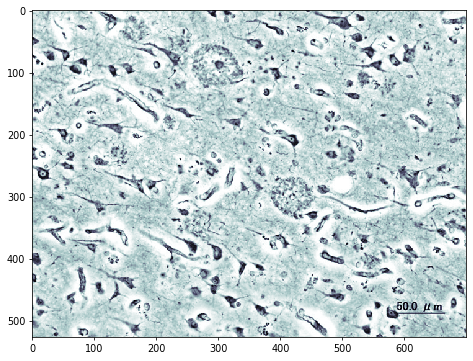

In [39]:
# K-means applied

np.random.seed(100)
fig, (ax1) = plt.subplots(1, 1,figsize=(8, 8), dpi=70)
ax1.imshow(img, cmap='bone')
xx, yy = np.meshgrid(np.arange(img.shape[1]),np.arange(img.shape[0]))
img_df = pd.DataFrame(dict(x=xx.ravel(),y=yy.ravel(),intensity=img.ravel()))
img_df.sample(10)

**Applying K-means after rescaling compnonents**

Since distance is calculated and values of position are much greater than values of intensity, need rescaling to fit on same axis

x      y  intensity  group
group                                       
0     203252  1.260  1.450        161      0
      158169  3.345  1.125        168      0
      322782  0.410  2.305        171      0
1     123150  3.250  0.875        196      1
      257460  2.800  1.835        186      1
      117263  1.815  0.835        200      1
2     7326    1.630  0.050         50      2
      102839  3.195  0.730        110      2
      26753   0.765  0.190        110      2
3     335007  2.035  2.390        229      3
      37488   1.940  0.265        230      3
      303865  0.325  2.170        227      3

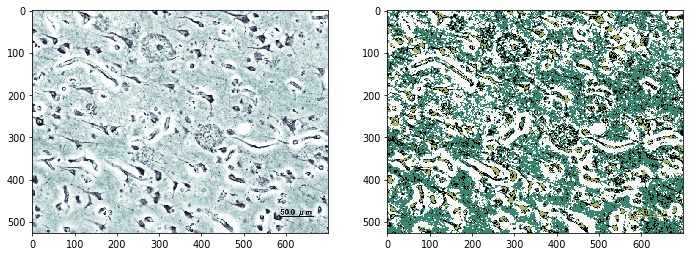

In [40]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state=100)
scale_img_df = img_df.copy()
scale_img_df.x = scale_img_df.x/200
scale_img_df.y = scale_img_df.y/200
scale_img_df['group'] = km.fit_predict(scale_img_df[['x','y','intensity']].values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8), dpi=70)
ax1.imshow(img, cmap='bone')
ax2.imshow(scale_img_df['group'].values.reshape(img.shape), cmap='gist_earth')
scale_img_df.groupby(['group']).apply(lambda x: x.sample(3))

In [ ]:
# img2 = scale_img_df['group'].values.reshape(img.shape) 
# plt.imshow(img2[img2.iloc[:]['group']==2], cmap='gist_earth')

# # plt.imshow(scale_img_df.iloc[:]['group']==2)


(527, 700) (527, 700)


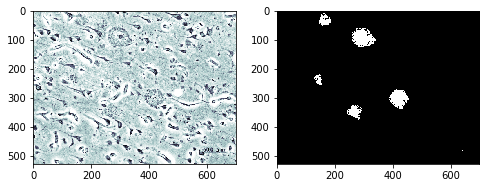

In [41]:
# Segmentation (Pixel Classification)

img_marked = cv2.imread('Alzheimer_presenile_onset_colored.jpg',0)
img_marked_edited = 1-(img_marked >0.5)
print(img.shape, img_marked_edited.shape)

np.random.seed(2018)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=72)
ax1.imshow(img, cmap='bone')
ax2.imshow(img_marked_edited, cmap='bone')

In [42]:
# train_img, valid_img = cell_img[:, :256], cell_img[:, 256:]
# train_mask, valid_mask = cell_seg[:, :256], cell_seg[:, 256:]

train_img, valid_img = img[:int(img.shape[0]/2),:], img[int(img.shape[0]/2):,:]
train_mask, valid_mask = img_marked_edited[:int(img.shape[0]/2),:], img_marked_edited[int(img.shape[0]/2):,:]

print('Training', train_img.shape, train_mask.shape)
print('Validation Data', valid_img.shape, valid_mask.shape)

Training (263, 700) (263, 700)
Validation Data (264, 700) (264, 700)


Text(0.5, 1.0, 'Validation Mask')

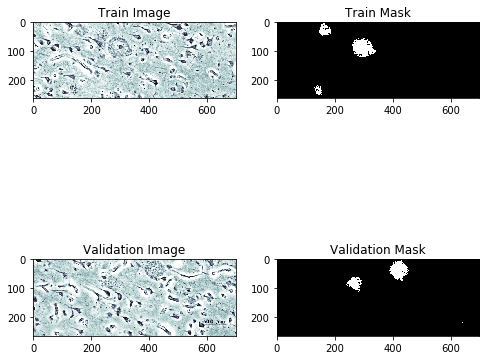

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8), dpi=72)
ax1.imshow(train_img, cmap='bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap='bone')
ax2.set_title('Train Mask')

ax3.imshow(valid_img, cmap='bone')
ax3.set_title('Validation Image')
ax4.imshow(valid_mask, cmap='bone')
ax4.set_title('Validation Mask')

# 9) Single Object Analysis

**Procedure:**
Started with “ground truth” file as the threshold 
Performed component labeling and shape analysis

In [46]:
# 2D Analysis: Here we work with a single 2D slice to get started and take it randomly from the middle

from skimage.measure import label # for labeling regions
from skimage.measure import regionprops # for shape analysis
import numpy as np # for matrix operations and array support
from skimage.color import label2rgb # for making overlay plots
import matplotlib.patches as mpatches # for showing rectangles and annotations
# from skimage.util.montage import montage2d # for making 3d montages from 2D images

print("Data Loaded, Dimensions", img.shape,'->',img_marked_edited.shape)

# em_idx = np.random.permutation(range(img.shape[0]))[0]
em_slice = img
em_thresh = img_marked_edited
print("Slice Loaded, Dimensions", em_slice.shape)

Data Loaded, Dimensions (527, 700) -> (527, 700)
Slice Loaded, Dimensions (527, 700)


Text(0.5, 1.0, 'Overlayed')

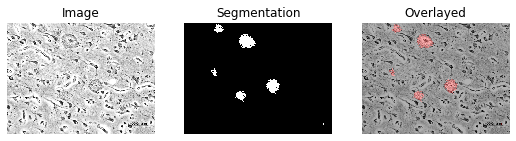

In [47]:
# Show the slice and threshold
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (9, 4))
ax1.imshow(em_slice, cmap = 'gray')
ax1.axis('off')
ax1.set_title('Image')
ax2.imshow(em_thresh, cmap = 'gray')
ax2.axis('off')
ax2.set_title('Segmentation')

# Here we mark the threshold on the original image

ax3.imshow(label2rgb(em_thresh,em_slice, bg_label=0))
ax3.axis('off')
ax3.set_title('Overlayed')

Text(0.5, 1.0, 'Overlayed')

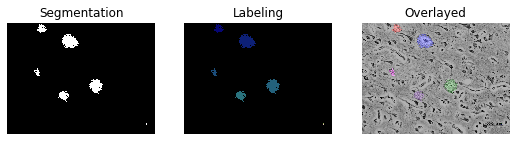

In [48]:
# Make connected component labels
em_label = label(em_thresh)

# Show the segmentation, labels and overlay
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (9, 4))
ax1.imshow(em_thresh, cmap = 'gray')
ax1.axis('off')
ax1.set_title('Segmentation')
ax2.imshow(em_label, cmap = plt.cm.gist_earth)
ax2.axis('off')
ax2.set_title('Labeling')

# Here we mark the threshold on the original image
ax3.imshow(label2rgb(em_label,em_slice, bg_label=0))
ax3.axis('off')
ax3.set_title('Overlayed')

# 10) Shape Analysis

<br>

 - Performed shape analysis on the image and calculated basic shape parameters for each
 - Bounding box: tells us what is the extent of our object in x,y,z
 - Allows us to get very simple measurements for what we're looking at 

In [49]:
'''For shape analysis we use the regionprops function which calculates the area, 
# perimeter, and other features for a shape'''

# The analysis creates a list of these with one for each label in the original image.
shape_analysis_list = regionprops(em_label)
first_region = shape_analysis_list[0]
print('List of region properties for',len(shape_analysis_list), 'regions')
print('Features Calculated:',', '.join([f for f in dir(first_region) if not f.startswith('_')]))

List of region properties for 24 regions
Features Calculated: area, bbox, bbox_area, centroid, convex_area, convex_image, coords, eccentricity, equivalent_diameter, euler_number, extent, filled_area, filled_image, image, inertia_tensor, inertia_tensor_eigvals, intensity_image, label, local_centroid, major_axis_length, max_intensity, mean_intensity, min_intensity, minor_axis_length, moments, moments_central, moments_hu, moments_normalized, orientation, perimeter, slice, solidity, weighted_centroid, weighted_local_centroid, weighted_moments, weighted_moments_central, weighted_moments_hu, weighted_moments_normalized


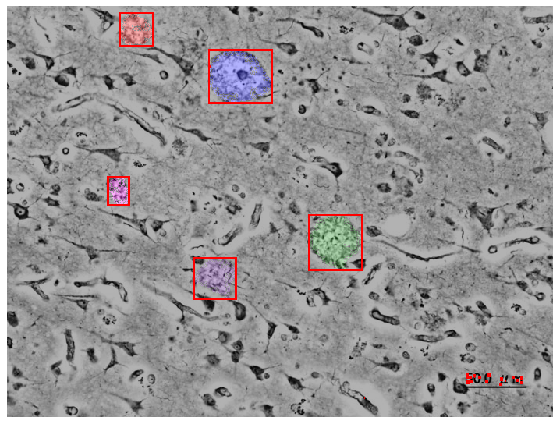

In [50]:
# Display shape analysis
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label2rgb(em_label,em_slice, bg_label=0))

for region in shape_analysis_list:
    # draw rectangle using the bounding box
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

# 11) Anisotropy

<br>

**Anisotropy:** Variation in magnitude according to direction of measurement

 - For characterizing shape, allows us to define metrics w.r.t. one another 
 - Take longest side and compare to shortest side (i.e. is it tall, skinny, short, round?) 

**Procedure:**
 - For plaques, drew bounding box around limits in order to have some idea of extents of object 
 - Provides representation for image shape

**Result:**
 - Low anisotropy values -> Plaques can be characterized as very circular and some nearly perfectly round

/Users/sav/opt/anaconda3/envs/robust_interpret/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/sav/opt/anaconda3/envs/robust_interpret/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


Label: 1 Anisotropy 0.03
Label: 2 Anisotropy 0.12
Label: 3 Anisotropy 0.12
Label: 4 Anisotropy 0.24
Label: 5 Anisotropy 0.03
Label: 6 Anisotropy 0.06
Label: 7 Anisotropy 1.00
Label: 8 Anisotropy 1.00
Label: 9 Anisotropy 1.00
Label: 10 Anisotropy 1.00
Label: 11 Anisotropy 1.00
Label: 12 Anisotropy 1.00
Label: 13 Anisotropy 1.00
Label: 14 Anisotropy 1.00
Label: 15 Anisotropy 1.00
Label: 16 Anisotropy 1.00
Label: 17 Anisotropy 1.00
Label: 18 Anisotropy 1.00
Label: 19 Anisotropy 1.00
Label: 20 Anisotropy 1.00
Label: 21 Anisotropy 1.00
Label: 22 Anisotropy 1.00
Label: 23 Anisotropy 1.00
Label: 24 Anisotropy 1.00


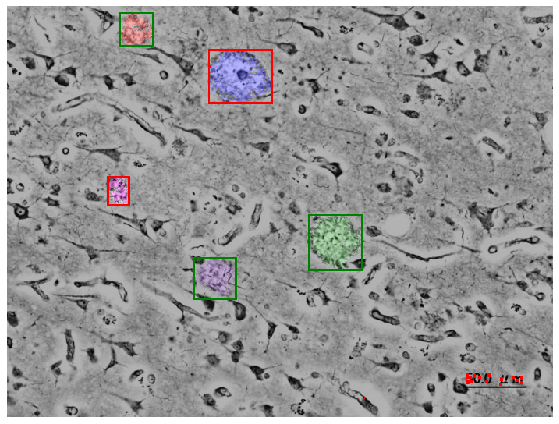

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label2rgb(em_label,em_slice, bg_label=0))

for region in shape_analysis_list:
    x1=region.major_axis_length
    x2=region.minor_axis_length
    if (x1+x2) > 0: 
        anisotropy = (x1-x2)/(x1+x2)
    # for anisotropic shapes use red for the others use green
    print('Label:',region.label,'Anisotropy %2.2f' % anisotropy)
    if anisotropy>0.1:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    else:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

# Are closer to circular than anisotropic..

# 12) Distance Mapping

**Purpose:**
 - Have circular plaques and distance map lets us take each point in map as distance that point is from given feature of interest (surface, ROI, center)

**Procedure:**
 - Took image and computed distance transform, where each pixel value represents distance away from boundary / background
 - **Foreground Background:** Information about the objects size and interior (more on next slide)
 - **Background Foreground:** Information about the distance / space between objects

     - How far apart are the plaques?
     - Pretty evenly spaced about, however, few lie closer together forming cluster in center of image (not seen on borders)


Text(0.5, 1.0, 'Distance Map\nBackground')

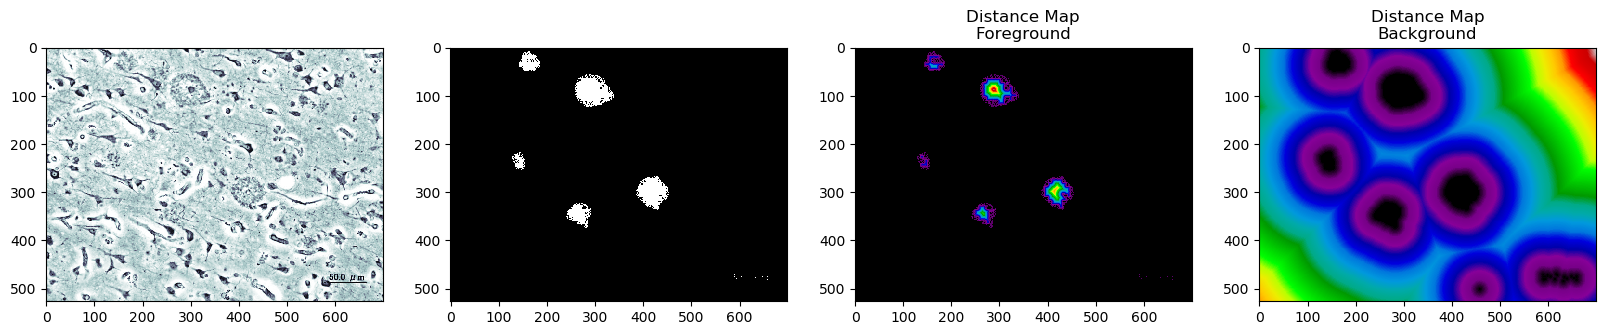

In [53]:
from skimage.morphology import binary_opening, binary_closing, disk
from scipy.ndimage import distance_transform_edt
from skimage.io import imread

bw_img = img
thresh_img = img_marked_edited
fg_dmap = distance_transform_edt(thresh_img)
bg_dmap = distance_transform_edt(1-thresh_img)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
ax1.imshow(bw_img, cmap='bone')
ax2.imshow(thresh_img, cmap='bone')
ax3.set_title('Segmentation')
ax3.imshow(fg_dmap, cmap='nipy_spectral')
ax3.set_title('Distance Map\nForeground')
ax4.imshow(bg_dmap, cmap='nipy_spectral')
ax4.set_title('Distance Map\nBackground')

# Plaque Size

 - Distance map used also to obtain visualization for what object generally looks like
 - Looking at the shape tensor - see it’s very round
 - Can utilize this information to understand general size of plaque
 - 22 is about as far away from edge that we get (i.e. can calculate radius of plaque = ~ largest distance shown)

(array([1.093e+03, 0.000e+00, 2.740e+02, 3.900e+01, 2.070e+02, 4.800e+01,
        1.780e+02, 5.400e+01, 1.560e+02, 3.100e+01, 8.600e+01, 1.060e+02,
        1.900e+01, 1.430e+02, 3.000e+01, 1.160e+02, 3.500e+01, 9.400e+01,
        2.100e+01, 8.700e+01, 2.800e+01, 6.100e+01, 3.600e+01, 6.200e+01,
        2.600e+01, 2.400e+01, 6.200e+01, 1.700e+01, 6.200e+01, 1.500e+01,
        5.500e+01, 1.500e+01, 4.200e+01, 2.100e+01, 3.500e+01, 1.200e+01,
        3.500e+01, 1.600e+01, 4.000e+00, 3.200e+01, 1.000e+01, 1.700e+01,
        1.100e+01, 1.500e+01, 4.000e+00, 1.300e+01, 4.000e+00, 6.000e+00,
        3.000e+00, 1.000e+00]),
 array([ 1.        ,  1.46041649,  1.92083297,  2.38124946,  2.84166594,
         3.30208243,  3.76249892,  4.2229154 ,  4.68333189,  5.14374837,
         5.60416486,  6.06458135,  6.52499783,  6.98541432,  7.4458308 ,
         7.90624729,  8.36666378,  8.82708026,  9.28749675,  9.74791323,
        10.20832972, 10.66874621, 11.12916269, 11.58957918, 12.04999566,
        12.

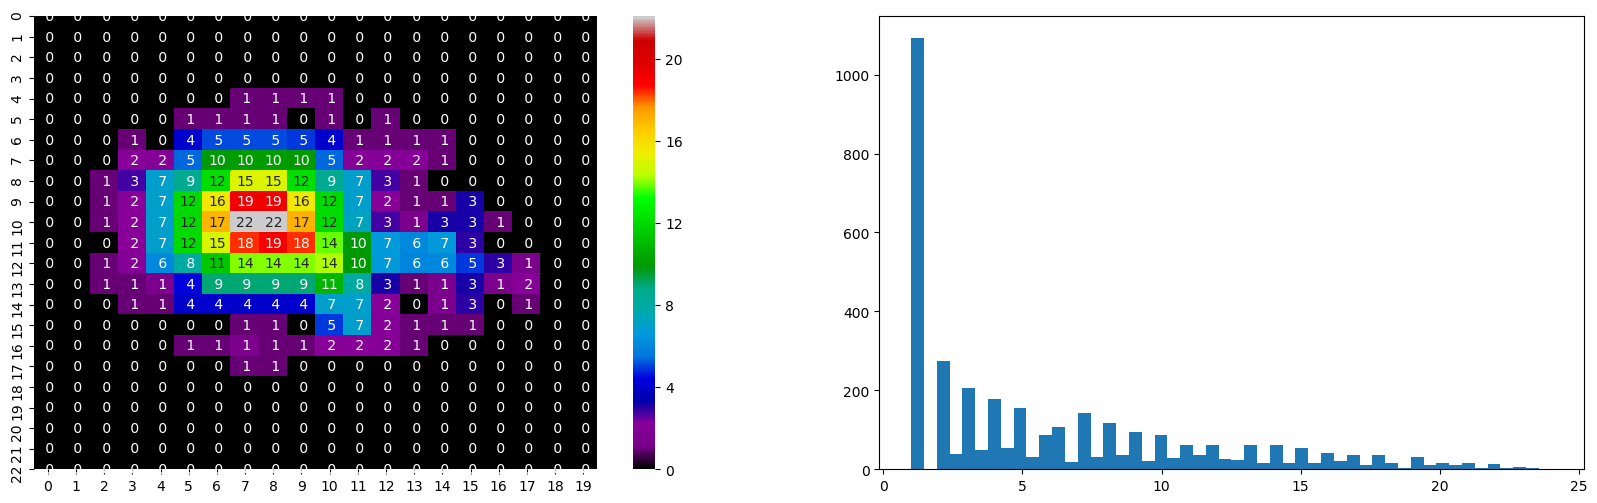

In [54]:
# Find size of the object
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=100)
fd_dmap_select = fg_dmap[38:152, 250:350]
sns.heatmap(fd_dmap_select[::5, ::5], annot=True,fmt="2.0f", cmap='nipy_spectral', ax=ax1, cbar=True)
ax2.hist(fd_dmap_select[fd_dmap_select > 0].ravel(), 50)